In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode
from classes import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

CT correction NET accesses the CT image from another class (such as `ForwardProjectionNet`) and rotates it, and obtains probability map every time `forward` is called. This means only 1 CT image needs to be stored

In [3]:
scale = 100

In [4]:

def draw_sphere(xv, yv, zv, center, radius, scale):
    return (((xv-center[0])**2 + (yv-center[1])**2 + (zv-center[2])**2) < radius**2).astype(np.float32) * scale

def draw_cylinder(xv, yv, zv, center, radius, height, scale):
    return scale * ((xv-center[0])**2 + (zv-center[2])**2 < radius**2) * (yv-center[1]<height/2) * (yv-center[1]>-height/2)
x_loc = 0.4*(np.random.uniform(size=10) - 0.5)
y_loc = 0.4*(np.random.uniform(size=10) - 0.5)
z_loc = 0.4*(np.random.uniform(size=10) - 0.5)
xv, yv, zv = np.meshgrid(np.linspace(-1,1,128), np.linspace(-1,1,128), np.linspace(-1,1,150), indexing='ij')
f_theo = draw_cylinder(xv, yv, zv, (0,0,0), 0.5, 1, 0.1 * scale) \
        + draw_cylinder(xv, yv, zv, (0.1,-0.4,0), 0.1, 0.5, 0.05 * scale) \
        + draw_cylinder(xv, yv, zv, (0.3,0.4,0.2), 0.3, 0.3, 0.1 * scale) 
for (x, y, z) in zip(x_loc, y_loc, z_loc):
        f_theo+= draw_cylinder(xv, yv, zv, (x, y, z), 0.3, 0.3, 0.03 * scale)
f_theo = draw_cylinder(xv, yv, zv, (0.1,-0.1,0.2), 0.5, 1, 0.5 * scale)
#f_theo = draw_sphere(xv, yv, zv, (0,0,0), 0.6, 0.5*scale) 
f = np.random.poisson(f_theo)
f = torch.tensor(f, dtype=torch.float32).to(device)
CT = draw_sphere(xv, yv, zv, (0.2,-0.2,0.2), 0.2, 10/32) 
CT = torch.tensor(CT).to(device) 

In [5]:
ct_net = CTCorrectionNet(CT.unsqueeze(dim=0), angle=0, dx=0.2, device=device)
f_attenuated = ct_net(f.to(device).unsqueeze(dim=0))

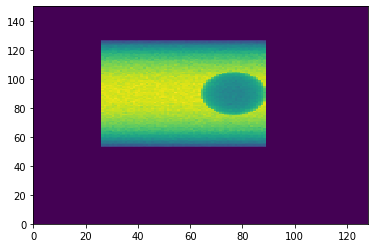

In [6]:
plt.pcolormesh((f_attenuated[0]).cpu().numpy().sum(axis=0).T)

In [7]:
np.transpose(CT.cpu().numpy()[:,::-1], (2,0,1)).tofile('stir_testing/CT.v')

In [8]:
angles = np.arange(0, 360, 3.75)
radii = 15*np.ones(len(angles))
dx = 0.2
shape = f.shape
collimator_slope = 1/100
collimator_intercept = 0

In [9]:
angle = 10
ct_net = CTCorrectionNet(CT.unsqueeze(dim=0), angle=angle, dx=dx, device=device)
psf_net = PSFCorrectionNet(radii[0], dx, f.shape, collimator_slope, collimator_intercept, device=device)

In [10]:
f_rotated = rotate_detector_z(f.unsqueeze(dim=0), angle).squeeze()
f_psf = psf_net(f_rotated.unsqueeze(dim=0)).squeeze()
f_psf_ct = ct_net(f_psf.unsqueeze(dim=0)).squeeze()

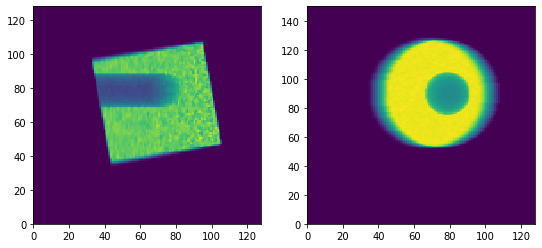

In [11]:
plt.subplots(1, 2, figsize=(9,4))
plt.subplot(121)
plt.pcolormesh(f_psf_ct[:,:,80].cpu().T)
plt.subplot(122)
plt.pcolormesh(f_psf_ct.sum(axis=0).cpu().T)

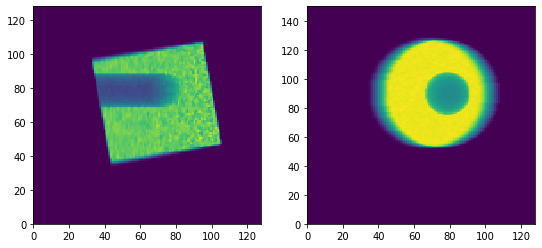

In [12]:
plt.subplots(1, 2, figsize=(9,4))
plt.subplot(121)
plt.pcolormesh(f_psf_ct[:,:,80].cpu().T)
plt.subplot(122)
plt.pcolormesh(f_psf_ct.sum(axis=0).cpu().T)

In [13]:
fp_net = ForwardProjectionNet(angles, dx, shape, radii, CT.unsqueeze(dim=0),
                             collimator_slope, collimator_intercept, device=device,
                            PSF_net_kernel_size=21)
bp_net = BackProjectionNet(angles, dx, shape, radii, CT.unsqueeze(dim=0),
                             collimator_slope, collimator_intercept, device=device,
                            PSF_net_kernel_size=21)

In [14]:
im = fp_net(f.unsqueeze(dim=0))
np.transpose(im[0].cpu().numpy(), (0,2,1)).tofile('stir_testing/Image.s') # for testing with STIR

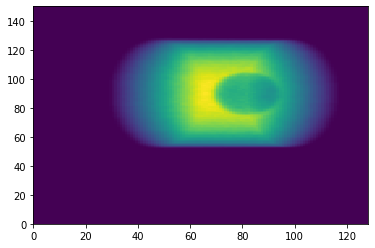

In [15]:
plt.pcolormesh(im[0].cpu()[15].T)

In [16]:
f_bp = bp_net(im)

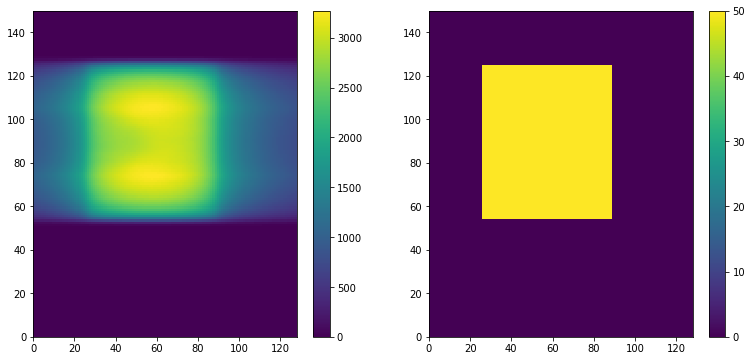

In [17]:
plt.subplots(1, 2, figsize=(13,6))
plt.subplot(121)
plt.pcolormesh(f_bp[0][60].cpu().detach().T)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(f_theo[60].T)
plt.colorbar()

# Maximum Liklihood

In [18]:
object_initial = torch.ones(f.unsqueeze(dim=0).shape).to(device)
osem_net = OSEMNet(object_initial, angles, dx, shape, radii=radii, CT=CT.unsqueeze(dim=0),
collimator_slope=collimator_slope, collimator_intercept=collimator_intercept, PSF_net_kernel_size=21, device=device)

In [19]:
object_predicted1 = osem_net(im, n_iters=10)

$ g = FP \cdot H_{CT} H_{PSF} f$

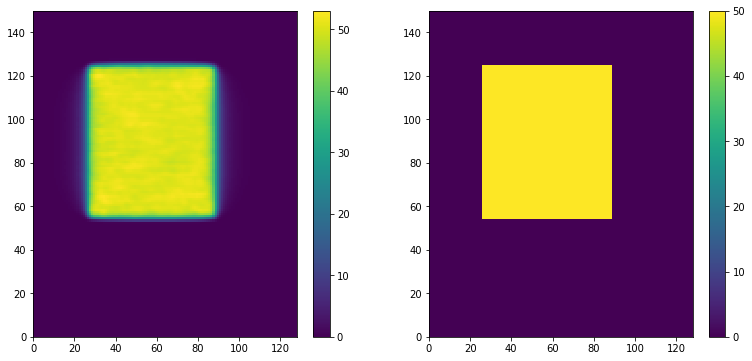

In [20]:
plt.subplots(1, 2, figsize=(13,6))
plt.subplot(121)
plt.pcolormesh(object_predicted1[0,60].cpu().T)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(f_theo[60].T)
plt.colorbar()

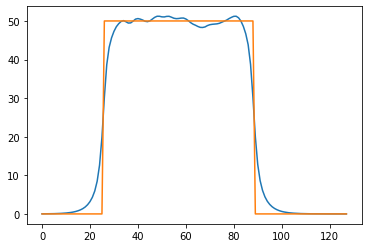

In [21]:
plt.plot(object_predicted1[0,60,:,80].cpu())
plt.plot(f_theo[60,:,62])

# STIR Testing

Run these cells using the stirenv kernel

In [30]:
stir_obj = np.fromfile('stir_testing/EMML_CT_10.v', dtype=np.float32)
stir_obj = stir_obj.reshape((150,128,128))[:,::-1,::-1]

In [31]:
tor_obj = np.transpose(object_predicted1[0].cpu().numpy(), (2,1,0))

In [32]:
truth_obj = np.transpose(f_theo, (2,1,0))

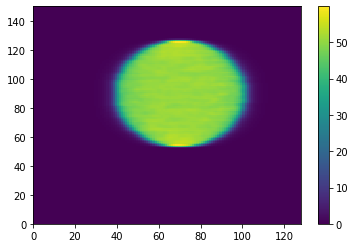

In [33]:
plt.pcolormesh((stir_obj)[:,80])
plt.colorbar()

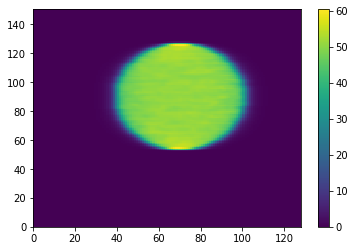

In [34]:
plt.pcolormesh(tor_obj[:,80])
plt.colorbar()

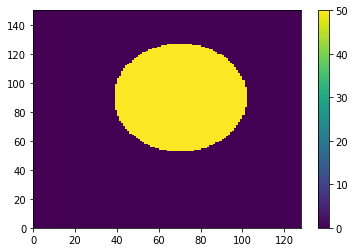

In [41]:
plt.pcolormesh(truth_obj[:,80])
plt.colorbar()

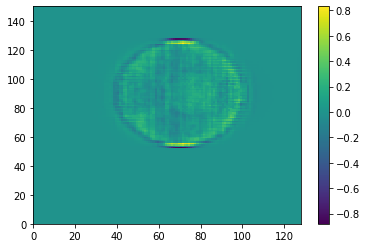

In [37]:
plt.pcolormesh((tor_obj-stir_obj)[:,80])
plt.colorbar()

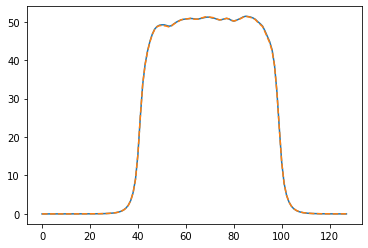

In [38]:
plt.plot((tor_obj)[75,80])
plt.plot((stir_obj)[75,80], '--')

In [39]:
np.mean((stir_obj-truth_obj)**2)

10.167469157357008

In [40]:
np.mean((tor_obj-truth_obj)**2)

10.266873371829217